# 0. Import Packages

In [1]:
#--Basics---------------
import pandas as pd
import numpy as np

#--Data Visualization----
import matplotlib.pyplot as plt
import seaborn as sns

#---Scikit-Learn--------
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MaxAbsScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, Lasso
from sklearn.impute import SimpleImputer
from sklearn.utils import estimator_html_repr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

#---Misc------------------
from mlxtend.feature_selection import SequentialFeatureSelector as MLSeqFeatSelector
from patsy import dmatrix
import statsmodels.api as sm


# 1. Define Data

In [6]:
class MyData:
    def __init__(self, file, target_cols):
        df = pd.read_csv(file)
        cols_numeric, cols_categorical = self.numeric_categorical_attributes(df)
        self.df = df
        self.cols_numeric = cols_numeric
        self.cols_categorical = cols_categorical
        self.onehot_dict = {}
        self.label_dict = {}
        self.target_cols = target_cols

    def __str__(self):
        return str(self.df.head())
        
    def numeric_categorical_attributes(self, df):
        numeric, categorical = (set(), set())
        for col in df.columns:
            try:
                df[col].apply(pd.to_numeric)
                numeric.add(col)
            except:
                categorical.add(col)
        return (numeric, categorical)

    def clean_out(self, drop_cols):
        # Drop columns that have many nulls.
        new_df = self.df.drop(columns=drop_cols, axis=1)
        new_cols_numeric, new_cols_categorical = [cols.difference(drop_cols) for cols in [self.cols_numeric, self.cols_categorical]]
        # Impute missing values with the median of the respective column
        for col in new_cols_numeric:
            median_value = self.df[col].median()
            new_df[col] = self.df[col].fillna(median_value)  
        # Impute missing values with the mode of the respective column
        for col in new_cols_categorical:
            mode_value = self.df[col].mode()[0]
            new_df[col] = self.df[col].fillna(mode_value)
        self.df = new_df
        self.cols_numeric = new_cols_numeric
        self.cols_categorical = new_cols_categorical

    def filterByColumn(self, filter_dict, drop = False):
        for col in filter_dict.keys():
            self.df = self.df[self.df.apply(lambda x: x[col] in filter_dict[col], axis = 1)]
        if drop:
            drop_cols = list(filter_dict.keys())
            self.cols_numeric, self.cols_categorical = [cols.difference(drop_cols) for cols in [self.cols_numeric, self.cols_categorical]]
            self.df = self.df.drop(columns = list(filter_dict.keys()), axis = 1).reset_index(drop=True)

    def label_encoding(self, cols):
        label_dict = {}
        for col in cols: 
            unique_values = list(set(self.df[col]))
            label_dict[col] = unique_values
            map_value = {unique_values[i] : i for i in range(len(unique_values))}
            self.df[col] = self.df[col].map(map_value)
            self.cols_categorical = self.cols_categorical.difference({col})
            self.cols_numeric = self.cols_numeric.union({col})
        self.label_dict = self.label_dict | label_dict

    def onehot(self, cols = None):
        cols = self.cols_categorical if cols is None else cols
        onehot_dict = dict([(col, list(set(self.df[col]))) for col in cols])
        cols_numeric = self.cols_numeric
        cols_categorical = self.cols_categorical
        for col in onehot_dict.keys():
            cols_numeric = cols_numeric.union(set(["{}_{}".format(col, i) for i in onehot_dict[col]]))
            cols_categorical = cols_categorical.difference({col})
        self.df = pd.get_dummies(self.df, columns = cols, dtype=int)
        self.cols_numeric = cols_numeric
        self.cols_categorical = cols_categorical
        self.onehot_dict = self.onehot_dict | onehot_dict

      


## Main

In [7]:
data = MyData("Amazon Sales FY2020-21.csv", target_cols = ["County", "City", "State"])
print(data.cols_categorical)

C:\Users\Ian\AppData\Local\Temp\ipykernel_15024\1475539011.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


{'City', 'Place Name', 'Gender', 'month', 'User Name', 'Last Name', 'Name Prefix', 'category', 'status', 'E Mail', 'State', 'payment_method', 'Sign in date', 'sku', 'order_date', 'County', 'bi_st', 'order_id', 'Region', 'full_name', 'Phone No. ', 'First Name', 'Middle Initial'}


# 2. Data Preparation

## Ian Functions

In [7]:
def clean_out_nulls(data, drop_cols, cols_numeric, cols_categorical):
    # Drop columns that have many nulls.
    result = data.drop(columns=drop_cols, axis=1)
    new_cols_numeric, new_cols_categorical = [cols.difference(drop_cols) for cols in [cols_numeric, cols_categorical]]
    # Impute missing values with the median of the respective column
    for col in new_cols_numeric:
        median_value = data[col].median()
        result[col] = data[col].fillna(median_value)  
    # Impute missing values with the mode of the respective column
    for col in new_cols_categorical:
        result[col] = data[col].fillna(data[col].mode()[0])
    
    return (result, new_cols_numeric, new_cols_categorical)

In [8]:
def remake_column(data, cols_numeric, cols_categorical, col_number, newName, newValues = None, myFunc = None):
    oldName = data.columns[col_number]
    new_data = data.rename(columns = {oldName: newName})
    if newValues is not None:
        oldValues = np.sort(data.loc[:, oldName].unique())
        new_data[newName] = new_data[newName].map(dict(list(zip(oldValues, newValues))))
    else:
        new_data[newName] = new_data[newName].map(myFunc)
    if oldName in cols_numeric:
        cols_numeric = cols_numeric.difference({oldName}).union({newName})
    else:
        cols_categorical = cols_categorical.difference({oldName}).union({newName})
    
    return new_data, cols_numeric, cols_categorical


## Main

In [8]:
drop_columns = ["order_id", "order_date", "item_id", "sku", "bi_st", "payment_method", "cust_id", "Place Name", "month", "year", "ref_num", 'Name Prefix', "First Name", "Middle Initial", "Last Name", "full_name", "Sign in date", "E Mail", "Sign in date", "Phone No. ", "User Name"]
data.clean_out(drop_columns)
data.filterByColumn({"status": ["complete", "received"]}, drop=True)
data.label_encoding(["Gender"])
print(data.cols_categorical)

{'Gender', 'State', 'County', 'Region', 'City', 'category'}


# 3. Exploratory Analysis

## Main

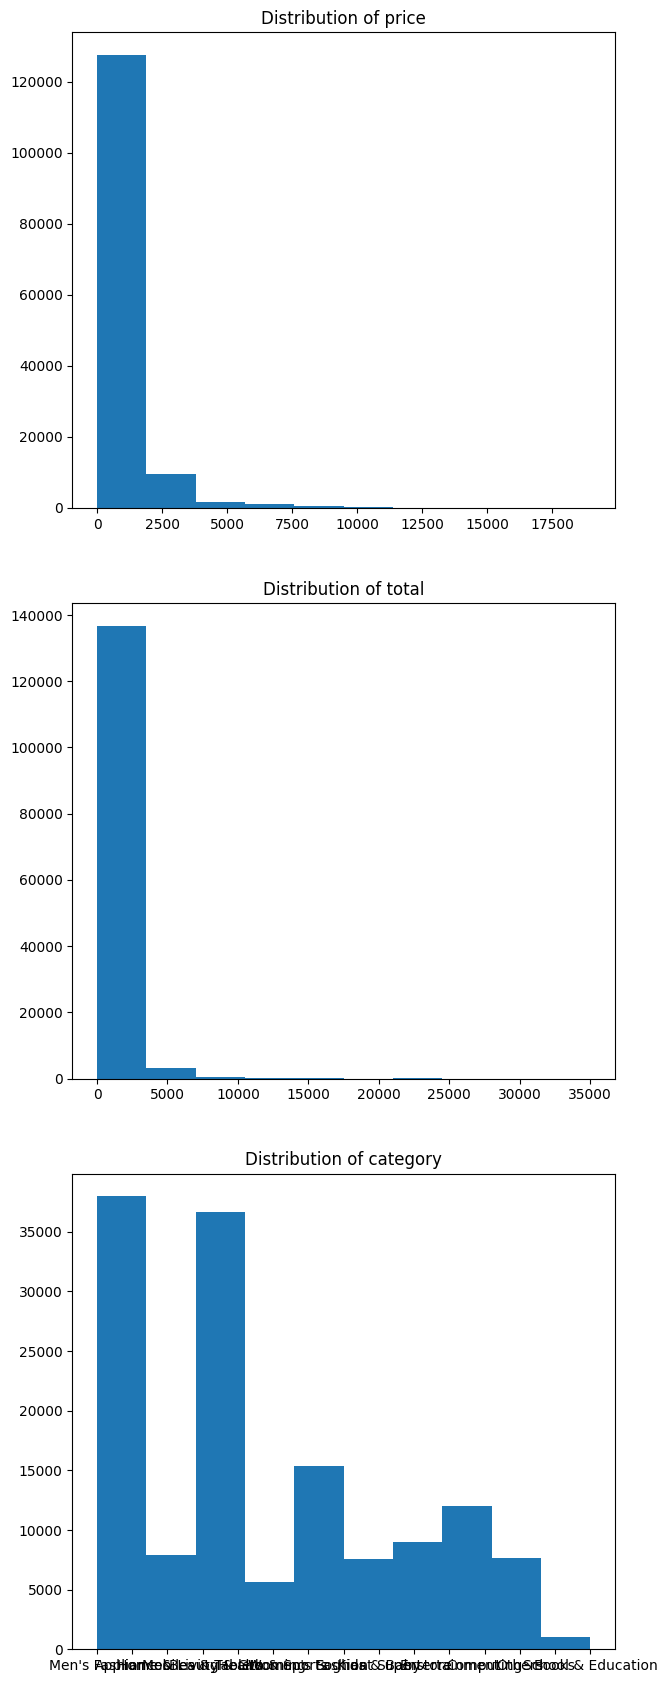

In [25]:
def histograms(data, features, size = 7):
    n = len(features)
    plt.figure(1, figsize = (size, size * n))
    for i in range(n):
        ax = plt.subplot(n, 1, i + 1)
        ax.title.set_text("Distribution of {}".format(features[i]))
        plt.hist(data.df[features[i]])
    plt.show()

histograms(data, ["price", "total", "category"])

# 4. Encoding

## Main

In [17]:
data.label_encoding("Gender")
data.onehot(["category", "Region"])

# 5. PCA

## Main

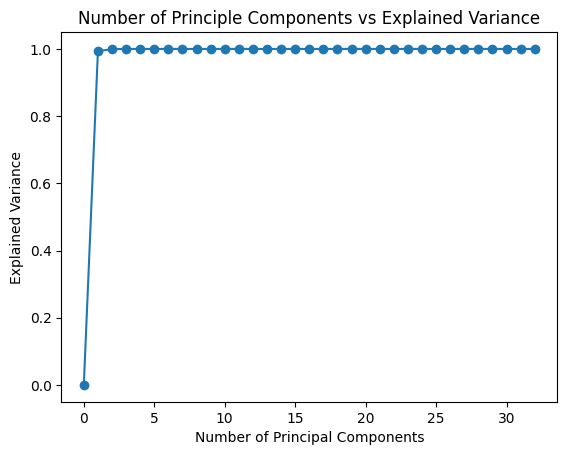

In [21]:
variance_pca = []
number_attributes = len(df.columns)
pca = PCA(n_components=number_attributes)
pca.fit(df)
explained_variance = pca.explained_variance_ratio_
for i in range(1, number_attributes):
    variance_list = list(explained_variance)[:i]
    variance_pca.append(sum(variance_list))
plt.plot([i for i in range(0, number_attributes)], [0] + variance_pca, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.title("Number of Principle Components vs Explained Variance")
plt.show()

# 6. Clustering

In [62]:
df

,qty_ordered,price,value,discount_amount,total,Gender,age,County,City,State,...,category_School & Education,category_Soghaat,category_Superstore,category_Women's Fashion,Region_Midwest,Region_Northeast,Region_South,Region_West,LAT,LNG
0,21,89.9,1798.0,0.0,1798.0,0,43,0.000092,0.000043,0.017308,...,0,0,0,0,0,0,1,0,34.924584,-99.867360
1,11,19.0,190.0,0.0,190.0,0,43,0.000092,0.000043,0.017308,...,0,0,0,0,0,0,1,0,34.924584,-99.867360
2,9,149.9,1199.2,0.0,1199.2,0,43,0.000092,0.000043,0.017308,...,0,0,0,0,0,0,1,0,34.924584,-99.867360
3,9,79.9,639.2,0.0,639.2,0,43,0.000092,0.000043,0.017308,...,0,0,0,0,0,0,1,0,34.924584,-99.867360
4,2,99.9,99.9,0.0,99.9,0,43,0.000092,0.000043,0.017308,...,0,0,0,0,0,0,1,0,34.924584,-99.867360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136907,2,168.5,168.5,0.0,168.5,1,52,0.000441,0.000881,0.030360,...,0,0,0,0,0,0,1,0,36.931166,-76.239720
136908,2,1284.2,1284.2,0.0,1284.2,1,52,0.000441,0.000881,0.030360,...,0,0,0,0,0,0,1,0,36.931166,-76.239720
136909,2,25.0,25.0,0.0,25.0,1,41,0.000760,0.000085,0.008256,...,0,0,0,1,0,0,0,1,62.908130,-160.066750
136910,2,200.0,200.0,0.0,200.0,1,62,0.001158,0.000362,0.049033,...,0,0,0,0,1,0,0,0,42.325364,-89.170527


In [22]:
def reverse_one_hot(df, features, name, categories):
    df_cat = df.loc[:, ["{}_{}".format(name, i) for i in categories]]
    n = range(len(categories))
    mapping = dict(list(zip(tuple([tuple([int(i == j) for i in n]) for j in n]), categories)))
    return pd.concat([df.loc[:, features], df_cat.index.to_series(name = name).map(lambda i: mapping[tuple(df_cat.loc[i, :])])], axis=1)

In [52]:
categories = ['Appliances', 
              'Beauty & Grooming', 
              'Books', 
              'Computing', 
              'Entertainment', 
              'Health & Sports', 
              'Home & Living', 
              'Kids & Baby', 
              "Men's Fashion", 
              'Mobiles & Tablets', 
              'Others', 
              'School & Education', 
              'Soghaat', 
              'Superstore', 
              "Women's Fashion"]
mydf = reverse_one_hot(df, ["LAT", "LNG", "total"], "category", categories)
mydf

,LAT,LNG,total,category
0,34.924584,-99.867360,1798.0,Men's Fashion
1,34.924584,-99.867360,190.0,Men's Fashion
2,34.924584,-99.867360,1199.2,Men's Fashion
3,34.924584,-99.867360,639.2,Men's Fashion
4,34.924584,-99.867360,99.9,Men's Fashion
...,...,...,...,...
136907,36.931166,-76.239720,168.5,Appliances
136908,36.931166,-76.239720,1284.2,Computing
136909,62.908130,-160.066750,25.0,Women's Fashion
136910,42.325364,-89.170527,200.0,Books


In [53]:
def makeClusters(df, features, k, plot = None):
    X = df[features]
    model = KMeans(n_clusters=k, n_init="auto").fit(X)
    Y = pd.concat([df, pd.Series(data=model.predict(X), name = "Cluster")], axis = 1)
    if plot is None:
        return Y, model
    else:
        colors = np.linspace(0, 1, k)
        colordict = dict(zip(range(k), colors))
        Y["Color"] = Y["Cluster"].map(colordict)
        plt.scatter(x = Y[features[0]], y = X[features[1]], c = Y["Color"])
        plt.xlabel(plot[0])
        plt.ylabel(plot[1])
        plt.title("Data in {} Clusters".format(k))
        plt.show()

In [63]:
def category_dist(sales, store_loc, k):
    sales_df, model = makeClusters(sales, ["LNG", "LAT"], k)
    store_clusters = pd.Series(data = model.predict(store_loc), name = "Cluster")
    def store_category(j):
        cluster_df = sales_df.loc[lambda df: df["Cluster"] == store_clusters[j]].drop(columns = ["Cluster"])
        dist_weight = lambda i: 1/np.sqrt(2 * np.pi) * np.exp((-(np.linalg.norm(cluster_df.loc[i, ["LNG", "LAT"]] - store_loc.loc[j, ["LNG", "LAT"]])) ** 2)/2)
        cluster_df["Weight"] = cluster_df.index.map(lambda i: dist_weight(i) * cluster_df.loc[i, "total"])
        category_series = cluster_df[["category", "Weight"]].groupby(by=["category"]).sum()["Weight"]
        total_weight = sum(category_series)
        category_series_complete = pd.concat([category_series, pd.Series(dict([(c, 0) for c in set(categories).difference(category_series.index)]))]).sort_index()
        return category_series_complete.map(lambda w: w / total_weight)
    data = dict([(j, list(store_category(j))) for j in store_loc.index])
    print(data)
    store_cats = pd.DataFrame.from_dict(data = data, columns = ["category_{}".format(c) for c in categories], orient="index")
    return pd.concat([store_loc, store_cats], axis=1)

In [64]:
store_loc = pd.DataFrame({"LNG": [-99.867360, -99.867360], "LAT": [34.924584, 34.924584]})
category_dist(mydf, store_loc, 20)


{0: [0.2181733772513874, 0.016829675770044305, 0.00044277610045147145, 0.017186270669771315, 0.21101993140141173, 0.01538394202597453, 0.005931163058918303, 0.0022072233407834842, 0.061459427920665784, 0.34727985709956083, 0.04492475975402515, 0.003833802903084741, 0.00023469318154105122, 0.02180404768807409, 0.03328905183430596], 1: [0.2181733772513874, 0.016829675770044305, 0.00044277610045147145, 0.017186270669771315, 0.21101993140141173, 0.01538394202597453, 0.005931163058918303, 0.0022072233407834842, 0.061459427920665784, 0.34727985709956083, 0.04492475975402515, 0.003833802903084741, 0.00023469318154105122, 0.02180404768807409, 0.03328905183430596]}


,LNG,LAT,category_Appliances,category_Beauty & Grooming,category_Books,category_Computing,category_Entertainment,category_Health & Sports,category_Home & Living,category_Kids & Baby,category_Men's Fashion,category_Mobiles & Tablets,category_Others,category_School & Education,category_Soghaat,category_Superstore,category_Women's Fashion
0,-99.86736,34.924584,0.218173,0.01683,0.000443,0.017186,0.21102,0.015384,0.005931,0.002207,0.061459,0.34728,0.044925,0.003834,0.000235,0.021804,0.033289
1,-99.86736,34.924584,0.218173,0.01683,0.000443,0.017186,0.21102,0.015384,0.005931,0.002207,0.061459,0.34728,0.044925,0.003834,0.000235,0.021804,0.033289
